In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
from qml import HybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# MNIST images are 28x28
IMAGE_SIZE = 28  
# Set to an int (e.g., 1000) for quick validation, None for full dataset
LIMIT_SAMPLES = 1000  

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset_full = datasets.MNIST(root='../data/MNIST', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='../data/MNIST', train=False, download=True, transform=transform)

# Limit dataset size if specified
if LIMIT_SAMPLES is not None:
    train_dataset = Subset(train_dataset_full, range(min(LIMIT_SAMPLES, len(train_dataset_full))))
    test_dataset = Subset(test_dataset_full, range(min(LIMIT_SAMPLES // 5, len(test_dataset_full))))
else:
    train_dataset = train_dataset_full
    test_dataset = test_dataset_full

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset_full[0][0].shape}")
print(f"Number of classes: {len(train_dataset_full.classes)}")

Training images: 1000
Test images: 200
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [4]:
# DataLoader configuration
BATCH_SIZE = 32

# Create data loaders from the pre-split datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Train batches: 32
Test batches: 7
Batch size: 32


## Create Quantum CNN Model

In [5]:
# Model configuration
from qml.ansatz.dense import DenseQCNNAnsatz


model = HybridQuantumMultiClassCNN(
    num_classes=10,  # MNIST has 10 classes (digits 0-9)
    kernel_size=8,
    stride=4,
    pool_size=8,
    encoding='dense',
    ansatz=DenseQCNNAnsatz(),
    measurement='z',
    trainable_quantum=False
)

model = model.to(device)
print(f"Model output classes: {model.num_classes}")

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliZ
Model output classes: 10


## Setup Training

In [6]:
from notebooks.multiclass_trainer import MultiClassTrainer

# Training configuration
LEARNING_RATE = 0.005
EPOCHS = 15

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [7]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 7/7 [01:01<00:00,  8.75s/it]


Epoch 1: Train Loss=2.2540, Train Acc=0.2190 | Test Loss=2.2289, Test Acc=0.2150


Evaluating: 100%|██████████| 7/7 [01:00<00:00,  8.58s/it]


Epoch 2: Train Loss=2.0468, Train Acc=0.3530 | Test Loss=2.1078, Test Acc=0.2400


Evaluating: 100%|██████████| 7/7 [01:00<00:00,  8.59s/it]


Epoch 3: Train Loss=1.8319, Train Acc=0.3890 | Test Loss=2.0142, Test Acc=0.2800


Evaluating: 100%|██████████| 7/7 [01:03<00:00,  9.02s/it]


Epoch 4: Train Loss=1.7096, Train Acc=0.4160 | Test Loss=1.9879, Test Acc=0.2900


Evaluating: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it]


Epoch 5: Train Loss=1.6099, Train Acc=0.4580 | Test Loss=1.9341, Test Acc=0.3200


Evaluating: 100%|██████████| 7/7 [00:59<00:00,  8.53s/it]


Epoch 6: Train Loss=1.5541, Train Acc=0.4810 | Test Loss=1.9297, Test Acc=0.3350


Evaluating: 100%|██████████| 7/7 [01:03<00:00,  9.10s/it]


Epoch 7: Train Loss=1.4985, Train Acc=0.4900 | Test Loss=1.9159, Test Acc=0.3550


Evaluating: 100%|██████████| 7/7 [01:03<00:00,  9.09s/it]


Epoch 8: Train Loss=1.4515, Train Acc=0.5290 | Test Loss=1.8849, Test Acc=0.3550


Evaluating: 100%|██████████| 7/7 [00:59<00:00,  8.49s/it]


Epoch 9: Train Loss=1.4024, Train Acc=0.5310 | Test Loss=1.8879, Test Acc=0.3400


Evaluating: 100%|██████████| 7/7 [01:00<00:00,  8.61s/it]


Epoch 10: Train Loss=1.3841, Train Acc=0.5390 | Test Loss=1.8955, Test Acc=0.3600


Evaluating: 100%|██████████| 7/7 [00:57<00:00,  8.24s/it]


Epoch 11: Train Loss=1.3247, Train Acc=0.5470 | Test Loss=1.8956, Test Acc=0.3400


Evaluating: 100%|██████████| 7/7 [01:00<00:00,  8.62s/it]


Epoch 12: Train Loss=1.2921, Train Acc=0.5750 | Test Loss=1.8900, Test Acc=0.3650


Evaluating: 100%|██████████| 7/7 [00:59<00:00,  8.54s/it]


Epoch 13: Train Loss=1.2566, Train Acc=0.5830 | Test Loss=1.8895, Test Acc=0.3300


Evaluating: 100%|██████████| 7/7 [00:57<00:00,  8.28s/it]


Epoch 14: Train Loss=1.2464, Train Acc=0.5740 | Test Loss=1.8724, Test Acc=0.3700


Evaluating: 100%|██████████| 7/7 [00:57<00:00,  8.27s/it]


Epoch 15: Train Loss=1.2229, Train Acc=0.5920 | Test Loss=1.8708, Test Acc=0.3400


## Train results

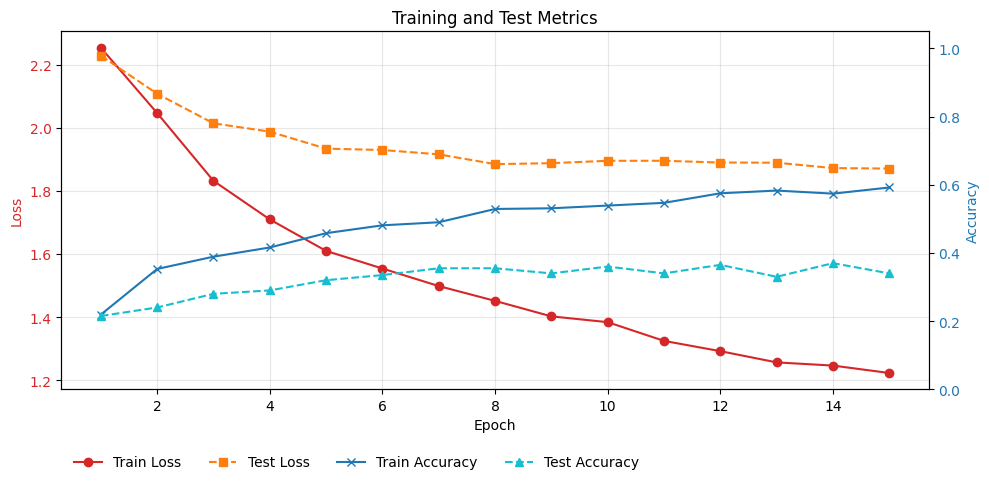

In [8]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 7/7 [00:56<00:00,  8.14s/it]



Final Test Results:
Test Loss: 1.8708
Test Accuracy: 0.3400


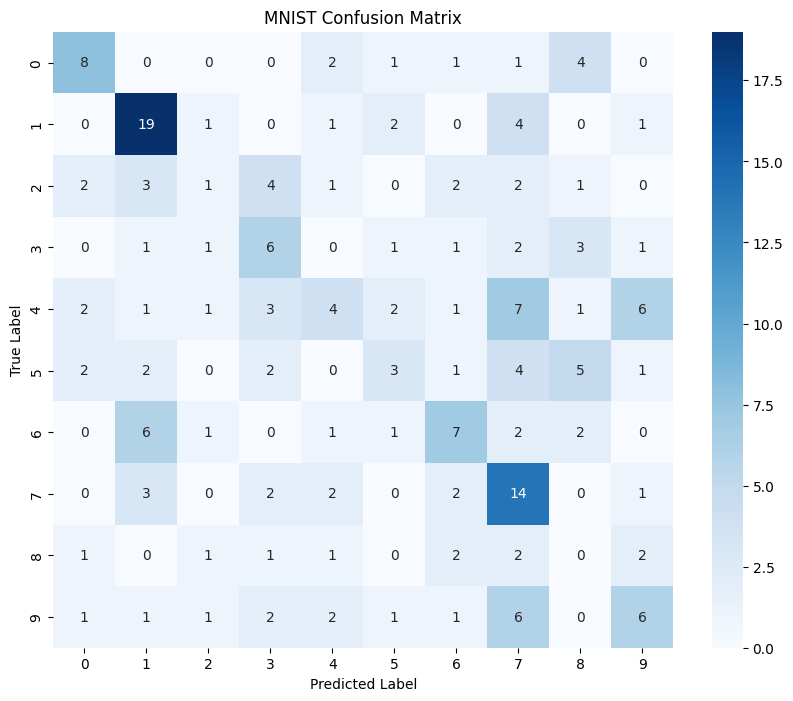


Per-Class Metrics:
Class    Precision    Recall       F1-Score    
------------------------------------------------
0        0.5000       0.4706       0.4848      
1        0.5278       0.6786       0.5937      
2        0.1429       0.0625       0.0870      
3        0.3000       0.3750       0.3333      
4        0.2857       0.1429       0.1905      
5        0.2727       0.1500       0.1935      
6        0.3889       0.3500       0.3684      
7        0.3182       0.5833       0.4118      
8        0.0000       0.0000       0.0000      
9        0.3333       0.2857       0.3077      

Overall Accuracy: 0.3400


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix for 10 classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('MNIST Confusion Matrix')
plt.show()

# Calculate per-class metrics
print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 48)

for i in range(10):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{i:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

# Overall metrics
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
print(f"\nOverall Accuracy: {total_correct / total_samples:.4f}")